# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Optimized EM version of PPCA with handling of missing data

In [2]:
# Probabilistic Principal Component Analysis (PPCA) Expectation-Maximization (EM) algorithm
def PPCA_EM(X, M, num_epochs=100):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    M: The dimensionality of the latent space.
    num_epochs: The number of iterations for the EM algorithm.

    Outputs:
    W_ML: The estimated weight matrix with shape (D, M).
    sigma: The estimated noise variance.
    mean: The estimated mean of the data.
    """

    # Get the number of data points (N) and the dimensionality of the data (D)
    N, D = X.shape

    # Initialize the weight matrix (W_ML), noise variance (sigma), and mean
    W_ML = np.random.normal(0, 1, size=(D, M))
    sigma = abs(np.random.normal(0, 1))
    mean = np.nanmean(X, axis=0)

    # Identify the missing values in the data
    X_missing = np.isnan(X)
    X[X_missing] = 0

    # Run the EM algorithm for num_epochs iterations
    for epoch in range(num_epochs):
        # Compute the M matrix and its inverse
        M_matrix = np.dot(W_ML.T, W_ML) + sigma * np.eye(M)
        M_matrix_inverse = np.linalg.inv(M_matrix)

        # E-step: Compute the expected values of the latent variables
        E_z_n = np.dot(np.dot(X - mean, W_ML), M_matrix_inverse)
        E_zn_zn = sigma * M_matrix_inverse + np.einsum('ij,ik->ijk', E_z_n, E_z_n)

        # Compute S*W directly
        SW = np.dot((X - mean).T, E_z_n)

        # M-step: Update the weight matrix and noise variance
        W_ML_new = np.dot(SW, np.linalg.inv(sigma * np.eye(M) + np.dot(W_ML.T, SW)))
        sigma = np.trace((X - mean).T @ (X - mean) - SW @ W_ML_new.T) / (N * D)

        # Update the weight matrix
        W_ML = W_ML_new

        # Update the missing values in the data
        for i in range(N):
            if np.any(X_missing[i]):
                X[i, X_missing[i]] = np.dot(E_z_n[i], W_ML.T[:, X_missing[i]]) + mean[X_missing[i]]

    return W_ML, sigma, mean


# Function to project the data to the latent space
def project_to_latent_space(X, W_ML, sigma, M):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    W_ML: The weight matrix with shape (D, M).
    sigma: The noise variance.
    M: The dimensionality of the latent space.

    Outputs:
    E_z_n: The expected values of the latent variables.
    """

    # Compute the mean of the data
    mean = np.nanmean(X, axis=0)

    # Compute the M matrix and its inverse
    M_matrix = np.dot(W_ML.T, W_ML) + sigma * np.eye(M)
    M_matrix_inverse = np.linalg.inv(M_matrix)

    # Compute the expected values of the latent variables
    E_z_n = np.dot(np.dot(X - mean, W_ML), M_matrix_inverse)

    return E_z_n


# Basic tests

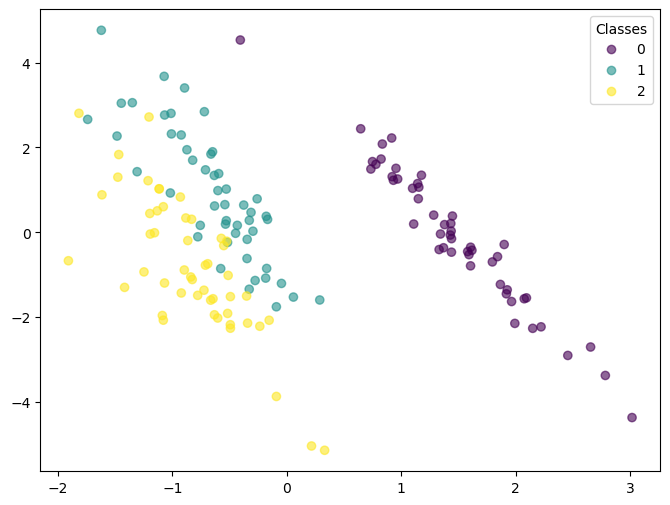

In [255]:
# Load Iris dataset
data = load_iris()
X = data.data  # input data
y = data.target  # labels

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Apply PPCA
W_ML, sigma, mean = PPCA_EM(X, M=2, num_epochs=200)

# Project data to latent space
Z = project_to_latent_space(X, W_ML, sigma, M=2)

# Visualize reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1], c=y, alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()


## PPCA vs PCA

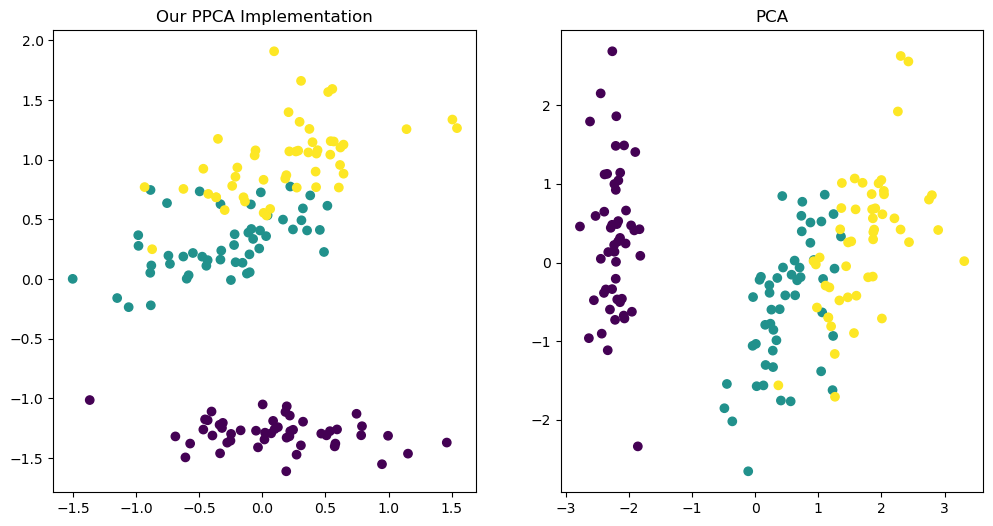

In [256]:
iris = datasets.load_iris()
X = iris.data

# Normalize the features to have mean=0 and variance=1
sc = StandardScaler()
X_std = sc.fit_transform(X)

# Set the dimensionality of the latent space
M = 2

# Run PPCA
W_ML, sigma, mean = PPCA_EM(X_std, M)

# Project the data to the latent space
Z = project_to_latent_space(X_std, W_ML, sigma, M)

# Plot the results
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.title('Our PPCA Implementation')

# Run PCA
model = PCA()
model.fit(X_std)
Z_ppca = model.transform(X_std)

# Plot the results
plt.subplot(1, 2, 2)
plt.scatter(Z_ppca[:, 0], Z_ppca[:, 1], c=iris.target)
plt.title('PCA')
plt.show()

## Our PPCA vs the PPCA module

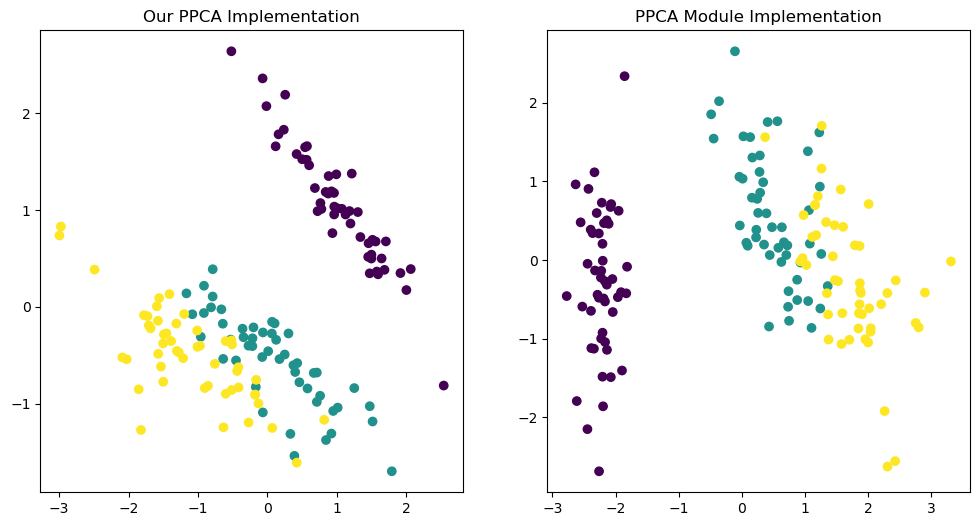

In [257]:
import ppca

iris = datasets.load_iris()
X = iris.data

# Normalize the features to have mean=0 and variance=1
sc = StandardScaler()
X_std = sc.fit_transform(X)

# Set the dimensionality of the latent space
M = 2

# Our PPCA
W_ML, sigma, mean = PPCA_EM(X_std, M)

# Project the data to the latent space
Z = project_to_latent_space(X_std, W_ML, sigma, M)

# Plot the results
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], c=iris.target)
plt.title('Our PPCA Implementation')

# The PPCA implementation from the ppca module
model = ppca.PPCA()
model.fit(X_std)
Z_ppca = model.transform(X_std)

# Plot the results
plt.subplot(1, 2, 2)
plt.scatter(Z_ppca[:, 0], Z_ppca[:, 1], c=iris.target)
plt.title('PPCA Module Implementation')
plt.show()

## Dimension reduction before classification 

In [258]:
# Load digits dataset
data = load_digits()
X = data.data  # input data
y = data.target  # labels

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_comp=15

# Apply PPCA on training data
W_ML, sigma, _ = PPCA_EM(X_train, M=n_comp, num_epochs=100)
Z_train_ppca = project_to_latent_space(X_train, W_ML, sigma, M=n_comp)
Z_test_ppca = project_to_latent_space(X_test, W_ML, sigma, M=n_comp)

# Apply PCA on training data
pca = PCA(n_components=n_comp)
Z_train_pca = pca.fit_transform(X_train)
Z_test_pca = pca.transform(X_test)

# Train and evaluate KNN classifier for each case
clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(Z_train_ppca, y_train)
y_pred_ppca = clf.predict(Z_test_ppca)
error_ppca = 1 - accuracy_score(y_test, y_pred_ppca)

clf.fit(Z_train_pca, y_train)
y_pred_pca = clf.predict(Z_test_pca)
error_pca = 1 - accuracy_score(y_test, y_pred_pca)


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
error_no_reduction = 1 - accuracy_score(y_test, y_pred)

print(f"Classification error with PPCA: {error_ppca}")
print(f"Classification error with PCA: {error_pca}")
print(f"Classification error with no reduction: {error_no_reduction}")

Classification error with PPCA: 0.019444444444444486
Classification error with PCA: 0.019444444444444486
Classification error with no reduction: 0.01666666666666672


## Handling of missing data

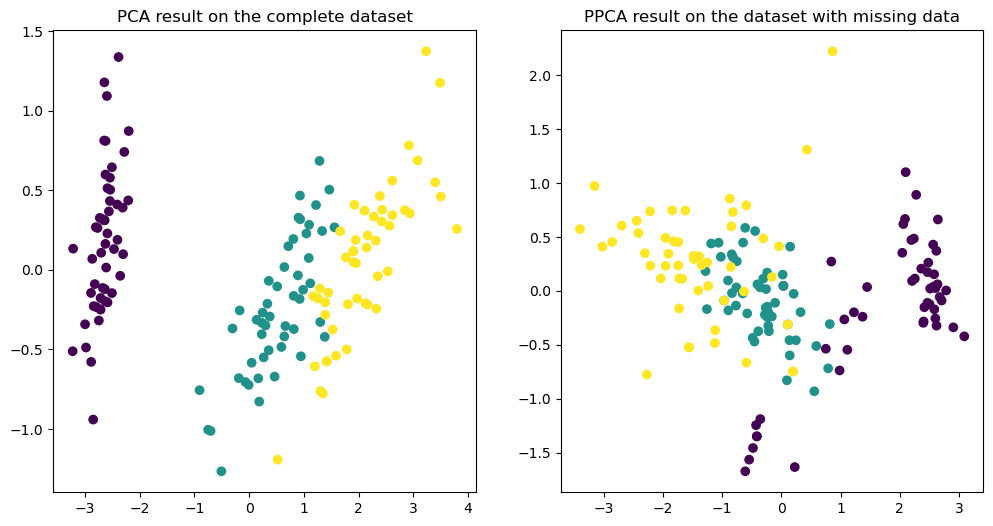

In [259]:
# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data

# Simulate missing data by randomly removing each value in the dataset with a probability of 30%
mask = np.random.choice([True, False], size=X.shape, p=[0.3, 0.7])
X_missing = X.copy()
X_missing[mask] = np.nan

# Perform PCA on the complete dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Perform PPCA on the dataset with missing data
W_ML, sigma, mean = PPCA_EM(X_missing, M=2, num_epochs=200)

X_ppca = project_to_latent_space(X_missing, W_ML, sigma, 2)

# Plot the PCA result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target)
plt.title('PCA result on the complete dataset')

# Plot the PPCA result
plt.subplot(1, 2, 2)
plt.scatter(X_ppca[:, 0], X_ppca[:, 1], c=iris.target)
plt.title('PPCA result on the dataset with missing data')

plt.show()

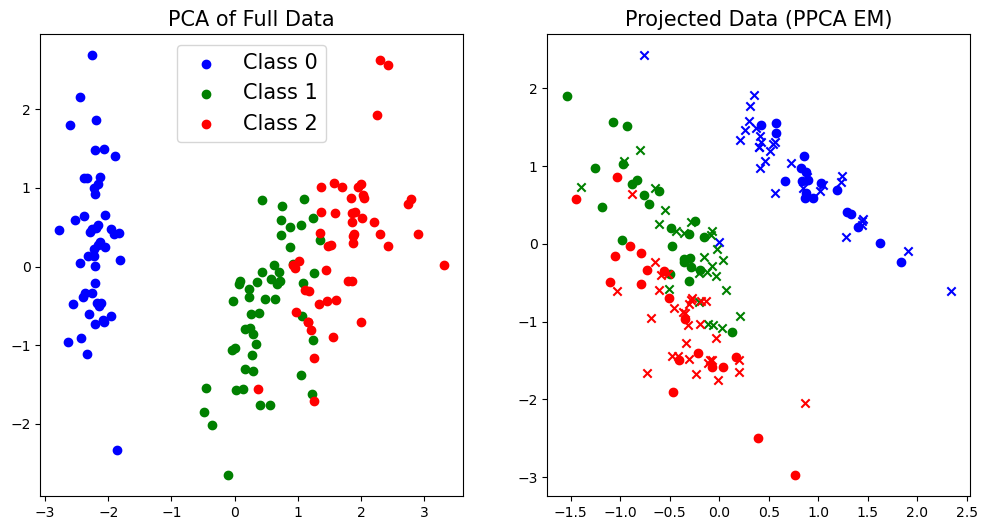

In [20]:
# Load and normalize the Iris dataset
iris = datasets.load_iris()
X_orig = iris.data
scaler = StandardScaler()
X_orig = scaler.fit_transform(X_orig)

# Apply PCA to the full data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_orig)

# Introduce missing data
missing_rate = 0.2  # 20% of the data is missing
X = X_orig.copy()
N, D = X.shape
missing_samples = np.random.choice(N*D, int(N*D*missing_rate), replace=False)
X[np.unravel_index(missing_samples, (N, D))] = np.nan

# Identify the rows that have at least one missing value
missing_rows = np.unique(np.unravel_index(missing_samples, (N, D))[0])

# Apply PPCA EM
W_ML, sigma, mean = PPCA_EM(X, M=2)

# Project to latent space
E_z_n = project_to_latent_space(X, W_ML, sigma, M=2)

# Create a mask for the missing data points
missing_mask = np.zeros(N, dtype=bool)
missing_mask[missing_rows] = True

# Define colors for each class
colors = ['blue', 'green', 'red']

# Visualize the results
plt.figure(figsize=(12, 6))

# Plot PCA of full data
plt.subplot(1, 2, 1)
for i in range(3):  # there are 3 classes in the Iris dataset
    plt.scatter(X_pca[iris.target == i, 0], X_pca[iris.target == i, 1], c=colors[i], label=f'Class {i}')
plt.title('PCA of Full Data',fontsize=15)
plt.legend(prop = { "size": 15 })

# Plot projected data (PPCA EM)
plt.subplot(1, 2, 2)
for i in range(3):  # there are 3 classes in the Iris dataset
    plt.scatter(E_z_n[(iris.target == i) & ~missing_mask, 0], E_z_n[(iris.target == i) & ~missing_mask, 1], c=colors[i])
    if np.any((iris.target == i) & missing_mask):
        plt.scatter(E_z_n[(iris.target == i) & missing_mask, 0], E_z_n[(iris.target == i) & missing_mask, 1], c=colors[i], marker='x', label=f'Class {i} (missing data)')
plt.title('Projected Data (PPCA EM)',fontsize=15)
plt.savefig("missingdata.png")
plt.show()


# Noise handling

## Isotropic noise assumption in PPCA

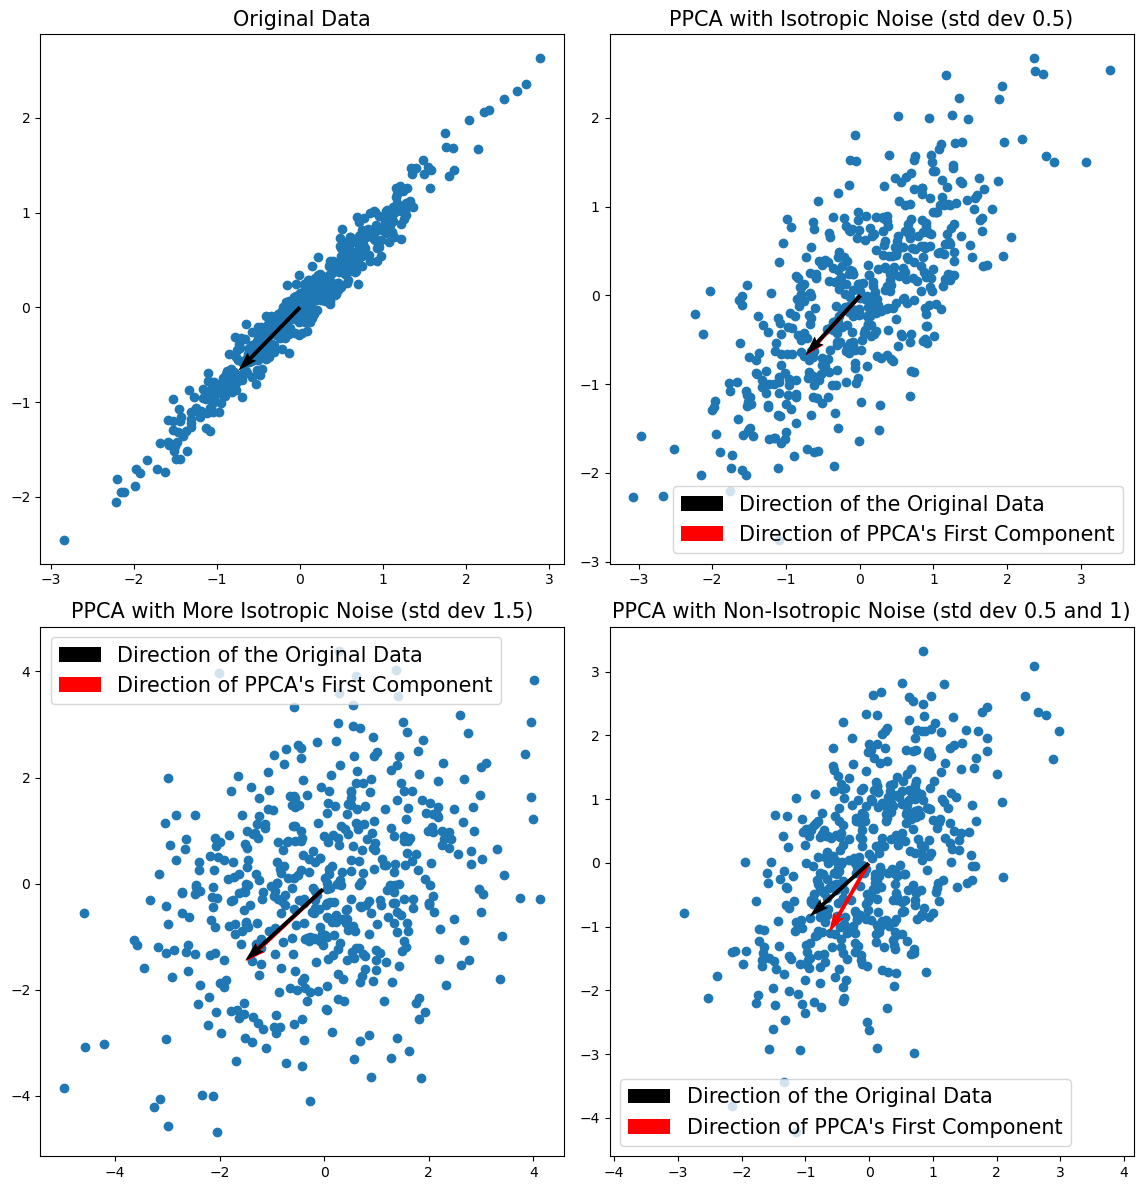

In [8]:
# Generate synthetic data
np.random.seed(0)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 500))).T
X -= np.mean(X, axis=0)  # Center the data

# Compute the direction of the original data
_, _, Vt = np.linalg.svd(X, full_matrices=False)
direction = Vt[0]

# Normalize the direction vector
direction /= np.linalg.norm(direction)

# Plot original data
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1])
original = plt.quiver(np.mean(X[:, 0]), np.mean(X[:, 1]), direction[0], direction[1], color='k', angles='xy', scale_units='xy', scale=1)
plt.title('Original Data', fontsize=15)

# Add isotropic noise
X_iso1 = X + np.random.normal(scale=0.5, size=X.shape)

# Applying PPCA_EM function
W_ML, sigma, mean = PPCA_EM(X_iso1, M=1, num_epochs=100)

# Normalize the PPCA direction vector
W_ML /= np.linalg.norm(W_ML)

# Plot original data and principal component
plt.subplot(222)
plt.scatter(X_iso1[:, 0], X_iso1[:, 1])
ppca = plt.quiver(mean[0], mean[1], W_ML[0, 0], W_ML[1, 0], color='r', angles='xy', scale_units='xy', scale=1)
plt.quiver(np.mean(X_iso1[:, 0]), np.mean(X_iso1[:, 1]), direction[0], direction[1], color='k', angles='xy', scale_units='xy', scale=1)
plt.title('PPCA with Isotropic Noise (std dev 0.5)',fontsize=15)
plt.legend([original, ppca], ['Direction of the Original Data', "Direction of PPCA's First Component"], prop = { "size": 15 })

# Add more isotropic noise
X_iso2 = X + np.random.normal(scale=1.5, size=X.shape)

# Applying PPCA_EM function
W_ML, sigma, mean = PPCA_EM(X_iso2, M=1, num_epochs=100)

# Normalize the PPCA direction vector
W_ML /= np.linalg.norm(W_ML)

# Plot original data and principal component
plt.subplot(223)
plt.scatter(X_iso2[:, 0], X_iso2[:, 1])
ppca = plt.quiver(mean[0], mean[1], W_ML[0, 0], W_ML[1, 0], color='r', angles='xy', scale_units='xy', scale=0.5)
plt.quiver(np.mean(X_iso2[:, 0]), np.mean(X_iso2[:, 1]), direction[0], direction[1], color='k', angles='xy', scale_units='xy', scale=0.5)
plt.title('PPCA with More Isotropic Noise (std dev 1.5)',fontsize=15)
plt.legend([original, ppca], ['Direction of the Original Data', "Direction of PPCA's First Component"], prop = { "size": 15 })

# Now let's add non-isotropic noise
X_noniso = X.copy()
X_noniso[:, 0] += np.random.normal(scale=0.3, size=X.shape[0])  # Noise in the first dimension
X_noniso[:, 1] += np.random.normal(scale=1, size=X.shape[0])  # Larger noise in the second dimension

# Applying PPCA_EM function
W_ML, sigma, mean = PPCA_EM(X_noniso, M=1, num_epochs=100)

# Normalize the PPCA direction vector
W_ML /= np.linalg.norm(W_ML)

# Plot original data and principal component
plt.subplot(224)
plt.scatter(X_noniso[:, 0], X_noniso[:, 1])
ppca = plt.quiver(mean[0], mean[1], W_ML[0, 0], W_ML[1, 0], color='r', angles='xy', scale_units='xy', scale=0.8)
plt.quiver(np.mean(X_noniso[:, 0]), np.mean(X_noniso[:, 1]), direction[0], direction[1], color='k', angles='xy', scale_units='xy', scale=0.8)
plt.title('PPCA with Non-Isotropic Noise (std dev 0.5 and 1)',fontsize=15)
plt.legend([original, ppca], ['Direction of the Original Data', "Direction of PPCA's First Component"],prop = { "size": 15 })

plt.axis("equal")
plt.tight_layout()
plt.savefig("isotropic.png")
plt.show()

# Rotational ambiguity

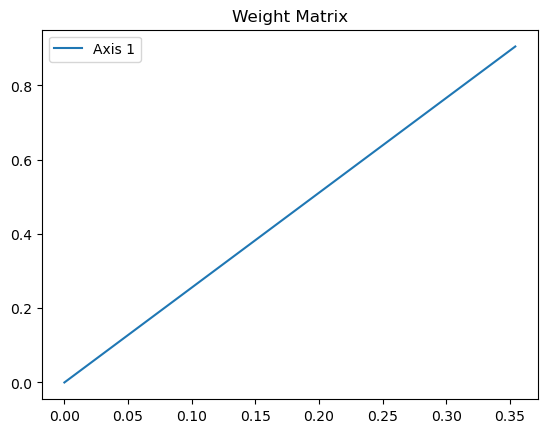

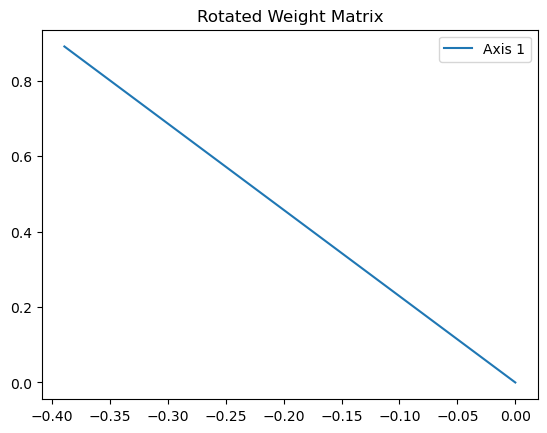

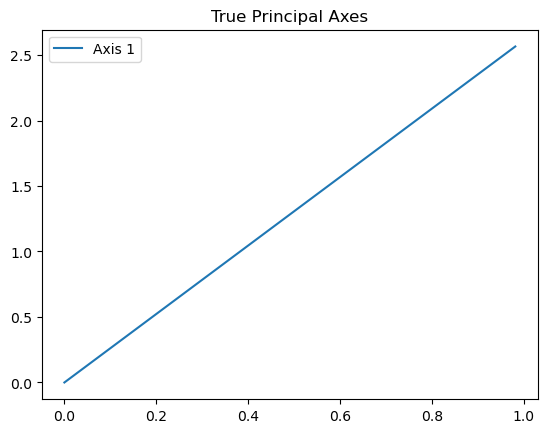

In [265]:
# Generate synthetic data
D, M = 2, 1
N = 100
sigma = 1.0
W_true = np.random.normal(0, 1, size=(D, M))
X = np.dot(np.random.normal(0, 1, size=(N, M)), W_true.T) + np.random.normal(0, sigma, size=(N, D))

# Apply PPCA
W_ML, sigma, mean = PPCA_EM(X, M)

# Visualize weight matrix
plt.figure()
for i in range(M):
    plt.plot([0, W_ML[0, i]], [0, W_ML[1, i]], label=f'Axis {i+1}')
plt.legend()
plt.title('Weight Matrix')

# Rotate weight matrix and visualize
theta = np.pi / 4  # rotation angle
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
W_rotated = np.dot(rotation_matrix, W_ML)

plt.figure()
for i in range(M):
    plt.plot([0, W_rotated[0, i]], [0, W_rotated[1, i]], label=f'Axis {i+1}')
plt.legend()
plt.title('Rotated Weight Matrix')

# Visualize true principal axes
plt.figure()
for i in range(M):
    plt.plot([0, W_true[0, i]], [0, W_true[1, i]], label=f'Axis {i+1}')
plt.legend()
plt.title('True Principal Axes')

plt.show()


# Classification experiment

In [267]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the Breast Cancer dataset
data = datasets.load_breast_cancer()
X_orig = data.data
y = data.target

# Normalize the data
scaler = StandardScaler()
X_orig = scaler.fit_transform(X_orig)

# Introduce missing data
missing_rate = 0.5  # 1% of the data is missing
X = X_orig.copy()
N, D = X.shape
missing_samples = np.random.choice(N*D, int(N*D*missing_rate), replace=False)
X[np.unravel_index(missing_samples, (N, D))] = np.nan

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA to the data with missing values imputed
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_imputed)
X_test_pca = pca.transform(X_test_imputed)

# Apply PPCA EM to the training data with missing values
W_ML, sigma, mean = PPCA_EM(X_train, M=2)
X_train_ppca = project_to_latent_space(X_train, W_ML, sigma, M=2)

# Fill in the missing values in the test data using the PPCA EM algorithm
X_test_ppca = X_test.copy()
for i in range(len(X_test_ppca)):
    observed_indices = np.where(~np.isnan(X_test_ppca[i]))[0]
    missing_indices = np.where(np.isnan(X_test_ppca[i]))[0]
    
    if len(missing_indices) > 0:
        W_observed = W_ML[np.ix_(observed_indices, range(2))]
        W_missing = W_ML[np.ix_(missing_indices, range(2))]
        
        mu_observed = X_test_ppca[i, observed_indices] - mean[observed_indices]
        
        X_test_ppca[i, missing_indices] = mean[missing_indices] + np.dot(np.dot(W_missing, np.linalg.inv(np.dot(W_observed.T, W_observed) + sigma * np.eye(2))), np.dot(W_observed.T, mu_observed))

# Project the test data to the latent space
X_test_ppca = project_to_latent_space(X_test_ppca, W_ML, sigma, M=2)

# Train and evaluate a k-NN classifier on the PCA data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)
y_pred_pca = knn.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

# Train and evaluate a k-NN classifier on the PPCA EM data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_ppca, y_train)
y_pred_ppca = knn.predict(X_test_ppca)
accuracy_ppca = accuracy_score(y_test, y_pred_ppca)

print(f'PCA Accuracy: {accuracy_pca}')
print(f'PPCA EM Accuracy: {accuracy_ppca}')


PCA Accuracy: 0.9385964912280702
PPCA EM Accuracy: 0.956140350877193


In [268]:
from sklearn.impute import SimpleImputer
# List of sklearn datasets
datasets_list = [datasets.load_wine, datasets.load_digits, datasets.load_iris]

# Percentage of total number of features to test
percentages = [5, 10, 20, 30, 40, 50]

# Initialize a dictionary to store the results
results = {}

# Loop over each dataset
for dataset in datasets_list:
    data = dataset()
    X_orig, y = data.data, data.target

    # Normalize the data
    scaler = StandardScaler()
    X_orig = scaler.fit_transform(X_orig)

    # Introduce missing data
    missing_rate = 0.2  # 20% of the data is missing
    X = X_orig.copy()
    N, D = X.shape
    missing_samples = np.random.choice(N*D, int(N*D*missing_rate), replace=False)
    X[np.unravel_index(missing_samples, (N, D))] = np.nan

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a dictionary to store the results for this dataset
    results[data['DESCR'].split('\n')[0]] = {}

    # Loop over each percentage
    for percentage in percentages:
        # Calculate the number of latent dimensions
        M = max(1,int(X.shape[1] * percentage / 100))

        # Apply PCA to the data with missing values imputed
        imputer = SimpleImputer(strategy='mean')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        pca = PCA(n_components=M)
        X_train_pca = pca.fit_transform(X_train_imputed)
        X_test_pca = pca.transform(X_test_imputed)

        # Apply PPCA EM to the training data with missing values
        W_ML, sigma, mean = PPCA_EM(X_train, M=M, num_epochs=200)
        X_train_ppca = project_to_latent_space(X_train, W_ML, sigma, M=M)

        # Fill in the missing values in the test data using the PPCA EM algorithm
        X_test_ppca = X_test.copy()
        for i in range(len(X_test_ppca)):
            observed_indices = np.where(~np.isnan(X_test_ppca[i]))[0]
            missing_indices = np.where(np.isnan(X_test_ppca[i]))[0]

            if len(missing_indices) > 0:
                W_observed = W_ML[np.ix_(observed_indices, range(M))]
                W_missing = W_ML[np.ix_(missing_indices, range(M))]

                mu_observed = X_test_ppca[i, observed_indices] - mean[observed_indices]

                X_test_ppca[i, missing_indices] = mean[missing_indices] + np.dot(np.dot(W_missing, np.linalg.inv(np.dot(W_observed.T, W_observed) + sigma * np.eye(M))), np.dot(W_observed.T, mu_observed))

        # Project the test data to the latent space
        X_test_ppca = project_to_latent_space(X_test_ppca, W_ML, sigma, M=M)

        # Train and evaluate a k-NN classifier on the PCA data
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train_pca, y_train)
        y_pred_pca = knn.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test, y_pred_pca)

        # Train and evaluate a k-NN classifier on the PPCA EM data
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train_ppca, y_train)
        y_pred_ppca = knn.predict(X_test_ppca)
        accuracy_ppca = accuracy_score(y_test, y_pred_ppca)

        # Store the results
        results[data['DESCR'].split('\n')[0]][M] = {'PCA Accuracy': accuracy_pca, 'PPCA EM Accuracy': accuracy_ppca}

# Convert the results to a DataFrame
results_df = pd.concat({k: pd.DataFrame(v).T for k, v in results.items()}, axis=0)

# Rename the index and columns for clarity
results_df.index.names = ['Dataset', 'Latent Space Dimension']
results_df.columns = ['PCA Classification Accuracy', 'PPCA EM Classification Accuracy']

print(results_df)

                                            PCA Classification Accuracy  \
Dataset             Latent Space Dimension                                
.. _wine_dataset:   1                                          0.750000   
                    2                                          1.000000   
                    3                                          0.972222   
                    5                                          1.000000   
                    6                                          0.972222   
.. _digits_dataset: 3                                          0.627778   
                    6                                          0.797222   
                    12                                         0.891667   
                    19                                         0.930556   
                    25                                         0.933333   
                    32                                         0.938889   
.. _iris_dataset:   1    

In [269]:
results_df

PCA Classification Accuracy  \
Dataset             Latent Space Dimension                                
.. _wine_dataset:   1                                          0.750000   
                    2                                          1.000000   
                    3                                          0.972222   
                    5                                          1.000000   
                    6                                          0.972222   
.. _digits_dataset: 3                                          0.627778   
                    6                                          0.797222   
                    12                                         0.891667   
                    19                                         0.930556   
                    25                                         0.933333   
                    32                                         0.938889   
.. _iris_dataset:   1                                          0.833333   
                    2                                          0.833333   

                                            PPCA EM Classification Accuracy  
Dataset             Latent Space Dimension                                   
.. _wine_dataset:   1                                              0.833333  
                    2                                              0.972222  
                    3                                              1.000000  
                    5                                              1.000000  
                    6                                              0.972222  
.. _digits_dataset: 3                                              0.611111  
                    6                                              0.841667  
                    12                                             0.905556  
                    19                                             0.941667  
                    25                                             0.933333  
                    32                                             0.827778  
.. _iris_dataset:   1                                              0.933333  
                    2                                              0.933333